# Brain blood vessel clog loss
### Second pre-processing script

Brings in the images created in step 1
The purpose of this code is to improve the images as data to the machine learning model
I have experimented with a number of different image enhancement methods here

In [1]:
import os
import cv2     
import math   
import matplotlib.pyplot as plt    
%matplotlib inline
import pandas as pd
import numpy as np    

from skimage.transform import resize   
from skimage import color, exposure, data, measure
import scipy.ndimage as ndi
import imageio
from skimage import transform
from scipy.ndimage import morphology
from skimage.transform import rotate, rescale
from skimage.util import crop
from skimage.color import label2rgb


In [2]:
def show_image(image, title='Image', cmap_type='gray'): 
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()
    
def middleProfile(image):
    cropped= image[15:27,:]
    profile= np.mean(cropped, axis=0)
    plt.plot(profile)
    return profile
                      
def cropToMiddle(image):
    cropped= image[11:33,:]
    return cropped

def standardBrightness(prefinal):
    themax= np.max(prefinal)
    prefinal= prefinal/themax
    return prefinal

def trimAndSmooth(image):
    
    bottom= np.percentile(image, 70)
    bottom_mask= np.where(image <= bottom, 0, 1)

    image_eq = exposure.equalize_hist(image, mask= bottom_mask)
    #show_image(image_eq, "histogram with mask")

    high = np.percentile(image_eq, 90)
    high_mask= np.where(image_eq >= high, 0.1, 0)

    layered= high_mask + image_eq
    #show_image(layered, "layered")
    
    return layered

def addAboveMean(image):
    mean= np.percentile(image, 85)
    result= np.where(image > mean,image + image, image)
    return result


1313


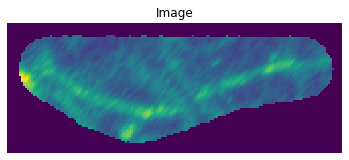

(64, 165, 4)
100109_0.png


In [3]:
myFiles= os.listdir("nano_processed")
myFiles= list(filter(lambda k: 'png' in k, myFiles))
print(len(myFiles))
myFiles= sorted(myFiles)

idx= 0
image= plt.imread("nano_processed/"+myFiles[0])
show_image(image)
print(image.shape)
print(myFiles[0])


In [ ]:
myIms= []

widths=[]
heights=[]

for file in myFiles:
    image= plt.imread("nano_processed/"+file)
    image= color.rgb2gray(image)
    if image.shape[0] > image.shape[1]:
        image= np.transpose(image)
    print(file)
    show_image(image)
    width= image.shape[1]
    height= image.shape[0]
    #themax= np.max(image)
    #themean= np.mean(image)
    widths.append(width)
    heights.append(height)
    #maxes.append(themax)
    #means.append(themean)
    myIms.append(image)
    
  

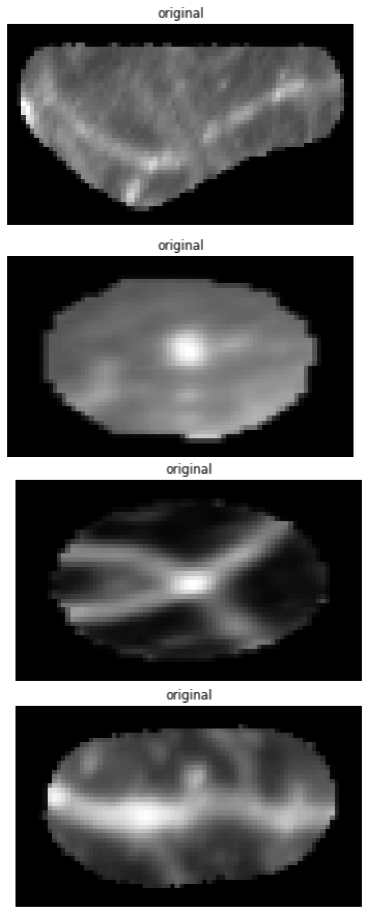


In [156]:
# oneheight= np.round(np.percentile(np.array(heights),50))
# onewidth= np.round(np.percentile(np.array(widths), 50))
# print(oneheight)
# print(onewidth)

oneheight= 44
onewidth= 76

resized_images= []

for image in myIms:
    resized= resize(image, (oneheight, onewidth), anti_aliasing=True)
    #show_image(resized)
    resized_images.append(resized)

In [157]:
array_dims= [len(resized_images),44,76]
masked_images= np.zeros(array_dims)
print(masked_images.shape)

(1313, 44, 76)


In [ ]:
# Aggressive masking
masked_list= []

for idx, image in enumerate(resized_images):

    image= standardBrightness(image)
    #print(myFiles[id])

    show_image(image, "original")
    bottom= np.percentile(image, 70)
    print(bottom)

    layered= trimAndSmooth(image)
    layered2= addAboveMean(layered)
    #show_image(layered2,"layered3")

    prefinal= layered2
    prefinal= standardBrightness(prefinal)
    #final_image= cropToMiddle(prefinal)
    
    final_image = prefinal
    #final_image= resize(prefinal, (25, 40), anti_aliasing=True)
    show_image(final_image,"final")
    #x= middleProfile(image)
    masked_images[idx,:,:]= final_image
    masked_list.append(final_image)
    
    

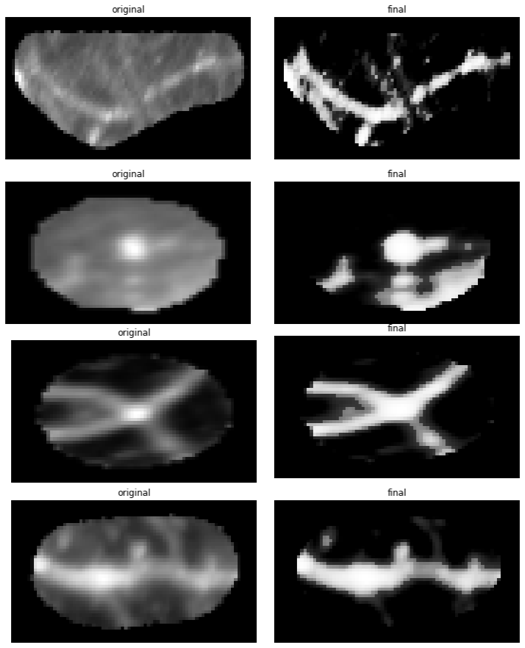


In [159]:



np.save("masked_images.npy",masked_images)





In [160]:
masked_images.shape




(1313, 44, 76)

In [161]:
len(masked_list)

1313

In [162]:
outdf= pd.DataFrame(myFiles,columns=['filename'])
outdf['id']= outdf.filename.str.slice(0,6)

print(outdf.head())
print(outdf.shape)

outdf.to_csv("outdf.csv")

       filename      id
0  100109_0.png  100109
1  100289_1.png  100289
2  100588_2.png  100588
3  100750_3.png  100750
4  102393_4.png  102393
(1313, 2)


In [40]:
datalist= pd.read_csv("dataWithPredictions.csv")
print(datalist.head())
print(datalist.shape)

       id  index        filename  stalled  negative  positive  prediction  \
0  153892      0  153892_121.png        0  0.997352  0.002648           0   
1  354479      1  354479_581.png        0  0.881942  0.118058           0   
2  105668      2   105668_15.png        1  0.083971  0.916029           1   
3  181118      3  181118_188.png        0  0.994849  0.005151           0   
4  307028      4  307028_476.png        0  0.982931  0.017069           0   

        category  
0  True Negative  
1  True Negative  
2  True Positive  
3  True Negative  
4  True Negative  
(600, 8)


In [41]:
folder1= "True Pos/"
folder2= "True Neg/"
folder3= "False Pos/"
folder4= "False Neg/"

In [45]:
for idx, image in enumerate(masked_list):
    if (datalist.category[idx]== 'True Positive'):
        thename= folder1+ datalist.filename[idx]
    elif (datalist.category[idx]== 'True Negative'):
        thename= folder2+ datalist.filename[idx]
    elif (datalist.category[idx]== 'False Positive'):
        thename= folder3+ datalist.filename[idx]
    else :
        thename= folder4+ datalist.filename[idx]
    plt.imsave(thename, image)

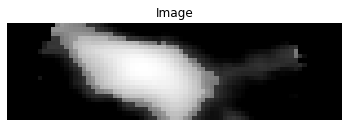

In [47]:
show_image(image)

105668_15.png


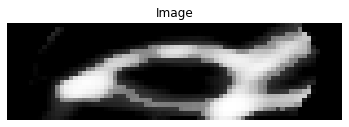

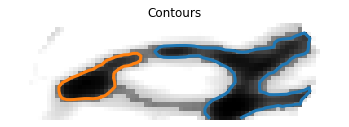

In [77]:
contours = measure.find_contours(image, 0.6)

# Shows the image with contours found
show_image_contour(image, contours)



In [60]:
def show_image_contour(image, contours):
    plt.figure()
    for n, contour in enumerate(contours):
        plt.plot(contour[:, 1], contour[:, 0], linewidth=3)
    plt.imshow(image, interpolation='nearest', cmap='gray_r')
    plt.title('Contours')
    plt.axis('off')
    plt.show()

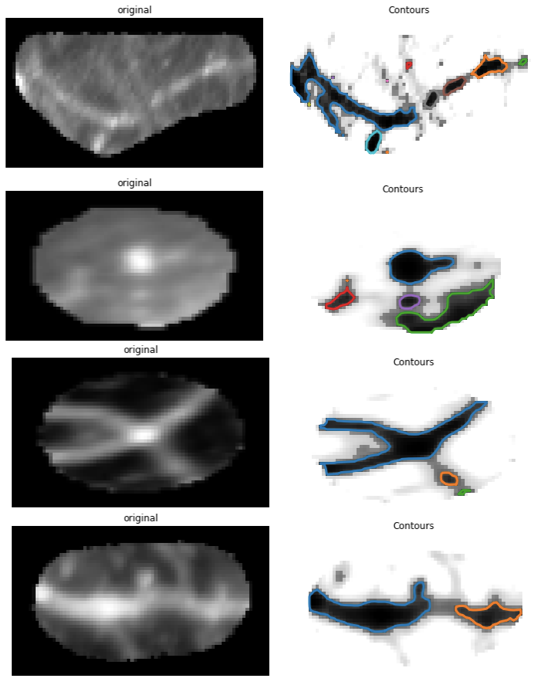

In [126]:
cdf= np.zeros((len(myFiles),10))
print(cdf.shape)

(600, 10)


for idx, image in enumerate(masked_list):

    contours = measure.find_contours(image, 0.7)
    print(len(contours))

    # Shows the image with contours found
    show_image_contour(image, contours)


    area, width, height = contourSize(contours[0])
    cdf[idx, 0]= len(contours)
    cdf[idx, 1]= area
    cdf[idx, 2]= width
    cdf[idx, 3]= height

    if (len(contours) > 1):
        area, width, height = contourSize(contours[1])
        cdf[idx, 4]= area
        cdf[idx, 5]= width
        cdf[idx, 6]= height

    if (len(contours) > 2):
        area, width, height = contourSize(contours[2])
        cdf[idx, 7]= area
        cdf[idx, 8]= width
        cdf[idx, 9]= height   
    
    


In [146]:
cdf.shape
cdfdf= pd.DataFrame(cdf)
cdfdf.head()
cdfdf.to_csv("cdfdf.csv")

In [120]:
def contourSize(contour):
    # Expand numpy dimmensions
    c = np.expand_dims(contour.astype(np.float32), 1)
    # Convert it to UMat object
    c = cv2.UMat(c)
    area = cv2.contourArea(c)
    size = cv2.minAreaRect(c)
    minc= np.min(contour[:,1])
    maxc= np.max(contour[:,1])
    minr= np.min(contour[:,0])
    maxr= np.max(contour[:,0])
    width= maxc - minc
    height= maxr - minr
    return area, width, height